# Clustering to Annotate All Cells

## <br> 1. Import Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import anndata as ad
import seaborn as sns

from scvi.model.utils import mde
from scipy import sparse
from anndata import AnnData
from anndata.experimental.multi_files import AnnCollection

/mnt/home/cholicog/anaconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set figure parameters.

In [2]:
sc.set_figure_params(figsize=(5,5))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
pd.options.display.max_colwidth = 200

## <br> 2. Import Prior Clustered Data

In [1]:
# Load preprocessed AnnData object from file
adata = ad.read_h5ad('./Adata_Objects/02a_RDDR_post-normalized.h5ad')


NameError: name 'ad' is not defined

In [4]:
print(adata.raw)

Raw AnnData with n_obs × n_vars = 115879 × 49633


In [5]:
print(adata) 

AnnData object with n_obs × n_vars = 115879 × 49633
    obs: 'OrigIdent', 'Barcode', 'OrigIdent-Barcode', 'Dose', 'Celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Celltype_colors', 'OrigIdent_colors', 'log1p'
    obsm: 'X_umap'
    layers: 'counts', 'log1p_counts'


In [6]:
bdata = adata.copy()

# <br> 3. Plot  Annotated Cells based on Previous Analyses

In [7]:
# View unique cell types
bdata.obs['Celltype'].unique()

['HSCs', 'Periportal Hepatocytes', 'LSECs', 'Cholangiocytes', 'Centrilobular Hepatocytes', ..., 'PFs', 'Neutrophils', 'pDCs', 'B Cells', 'T Cells']
Length: 11
Categories (11, object): ['B Cells', 'Centrilobular Hepatocytes', 'Cholangiocytes', 'HSCs', ..., 'PFs', 'Periportal Hepatocytes', 'T Cells', 'pDCs']

In [8]:
# Count the occurrences in adata
adata.obs['Celltype'].value_counts()

Celltype
Periportal Hepatocytes       50423
Centrilobular Hepatocytes    19374
LSECs                        14294
Macrophages                  13922
HSCs                          6600
B Cells                       3836
T Cells                       3776
Cholangiocytes                1365
Neutrophils                    929
pDCs                           749
PFs                            611
Name: count, dtype: int64

In [9]:
# Remove cells with missing Celltype annotations
bdata = bdata[~pd.isna(bdata.obs['Celltype'])]

In [10]:
bdata

View of AnnData object with n_obs × n_vars = 115879 × 49633
    obs: 'OrigIdent', 'Barcode', 'OrigIdent-Barcode', 'Dose', 'Celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Celltype_colors', 'OrigIdent_colors', 'log1p'
    obsm: 'X_umap'
    layers: 'counts', 'log1p_counts'

In [11]:
# Convert Celltype to categorical and reorder categories
bdata.obs.Celltype = bdata.obs.Celltype.astype("category")
bdata.obs.Celltype = bdata.obs['Celltype'].cat.reorder_categories(['Periportal Hepatocytes', 'Centrilobular Hepatocytes', 
                                                                   'LSECs',  'Macrophages', 'HSCs', 'B Cells', 
                                                                   'T Cells',  'Cholangiocytes', 'Neutrophils',
                                                                   'pDCs','PFs'
                                                                   ])#, "Null"])


/mnt/home/cholicog/anaconda3/envs/scvi/lib/python3.9/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [12]:
# Ensure index is of string type
bdata.obs.index = bdata.obs.index.astype(str)

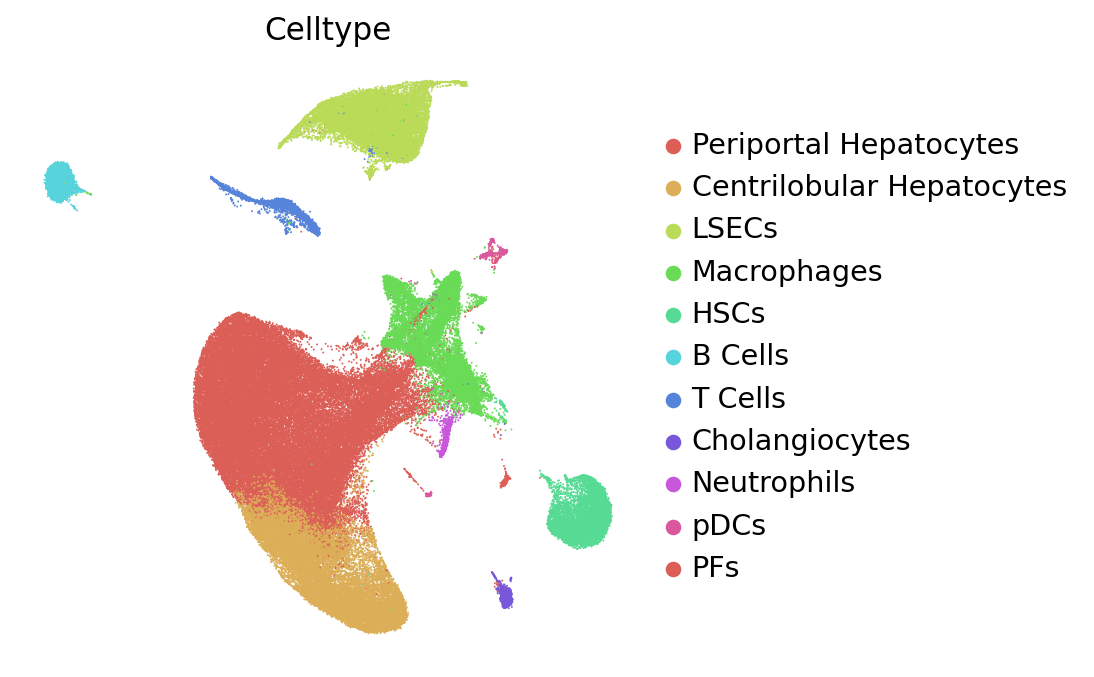

In [13]:
# UMAP plot colored by Celltype
sc.pl.umap(
    bdata,
    color=["Celltype"],
    frameon=False,
    palette = sns.color_palette("hls", 10),
    size=3,
    #save='_Clustering-Celltype_FINAL.pdf'
)

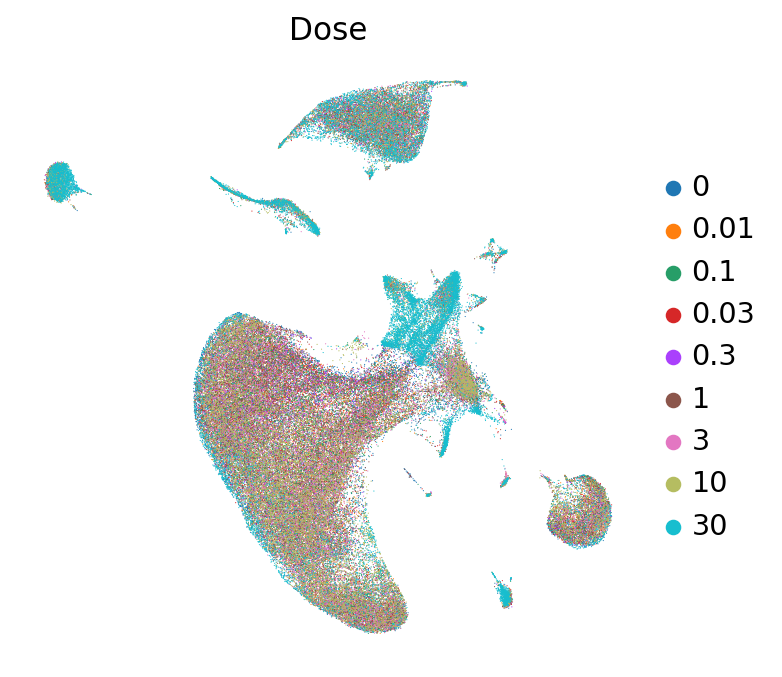

In [14]:
# UMAP plot colored by Dose, split across columns
sc.pl.umap(
    bdata,
    color=["Dose"],
    ncols=2,
    frameon=False,
)

In [15]:
cdata = bdata.copy()

In [16]:
print(cdata)

AnnData object with n_obs × n_vars = 115879 × 49633
    obs: 'OrigIdent', 'Barcode', 'OrigIdent-Barcode', 'Dose', 'Celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Celltype_colors', 'OrigIdent_colors', 'log1p', 'Dose_colors'
    obsm: 'X_umap'
    layers: 'counts', 'log1p_counts'


In [17]:
# Retain selected metadata columns in cdata
cdata.obs = cdata.obs[['OrigIdent','Barcode', 'OrigIdent-Barcode', 
                       'Dose',   
                       'Celltype',
                       'n_genes_by_counts', 'total_counts', 
                       'total_counts_mt', 'pct_counts_mt',]]
                       #'doublet_scores', 'predicted_doublets', 'doublet_info']]

In [18]:
print(cdata)

AnnData object with n_obs × n_vars = 115879 × 49633
    obs: 'OrigIdent', 'Barcode', 'OrigIdent-Barcode', 'Dose', 'Celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Celltype_colors', 'OrigIdent_colors', 'log1p', 'Dose_colors'
    obsm: 'X_umap'
    layers: 'counts', 'log1p_counts'


# <br> 4. Determine Marker Genes on Labled Cells

In [19]:
# Log1p-transform the expression values in cdata
sc.pp.log1p(cdata)

In [20]:
# Perform differential expression analysis across cell types using Wilcoxon rank-sum test
sc.tl.rank_genes_groups(cdata, 
                        'Celltype', 
                        method='wilcoxon', 
                        key_added = "Celltype_Wilcoxon")

### <br> Example on how to view results

In [21]:
# Retrieve top 10 marker genes for Periportal Hepatocytes
sc.get.rank_genes_groups_df(cdata, 
                            group='Periportal Hepatocytes', 
                            key='Celltype_Wilcoxon')[:10]

,names,scores,logfoldchanges,pvals,pvals_adj
0,lnc14746,222.191833,2.846554,0.0,0.0
1,lnc31755,221.583054,3.671747,0.0,0.0
2,Slc7a2,208.392166,2.908445,0.0,0.0
3,Ass1,198.995590,2.843006,0.0,0.0
4,Hc,175.822601,2.206450,0.0,0.0
5,Cps1,171.629456,1.928886,0.0,0.0
6,Abcb11,168.682190,1.766316,0.0,0.0
7,Mug2,165.588104,2.308929,0.0,0.0
8,Uroc1,165.251404,2.843746,0.0,0.0
9,Adk,163.573700,1.323604,0.0,0.0


### <br> Example on how to plot results

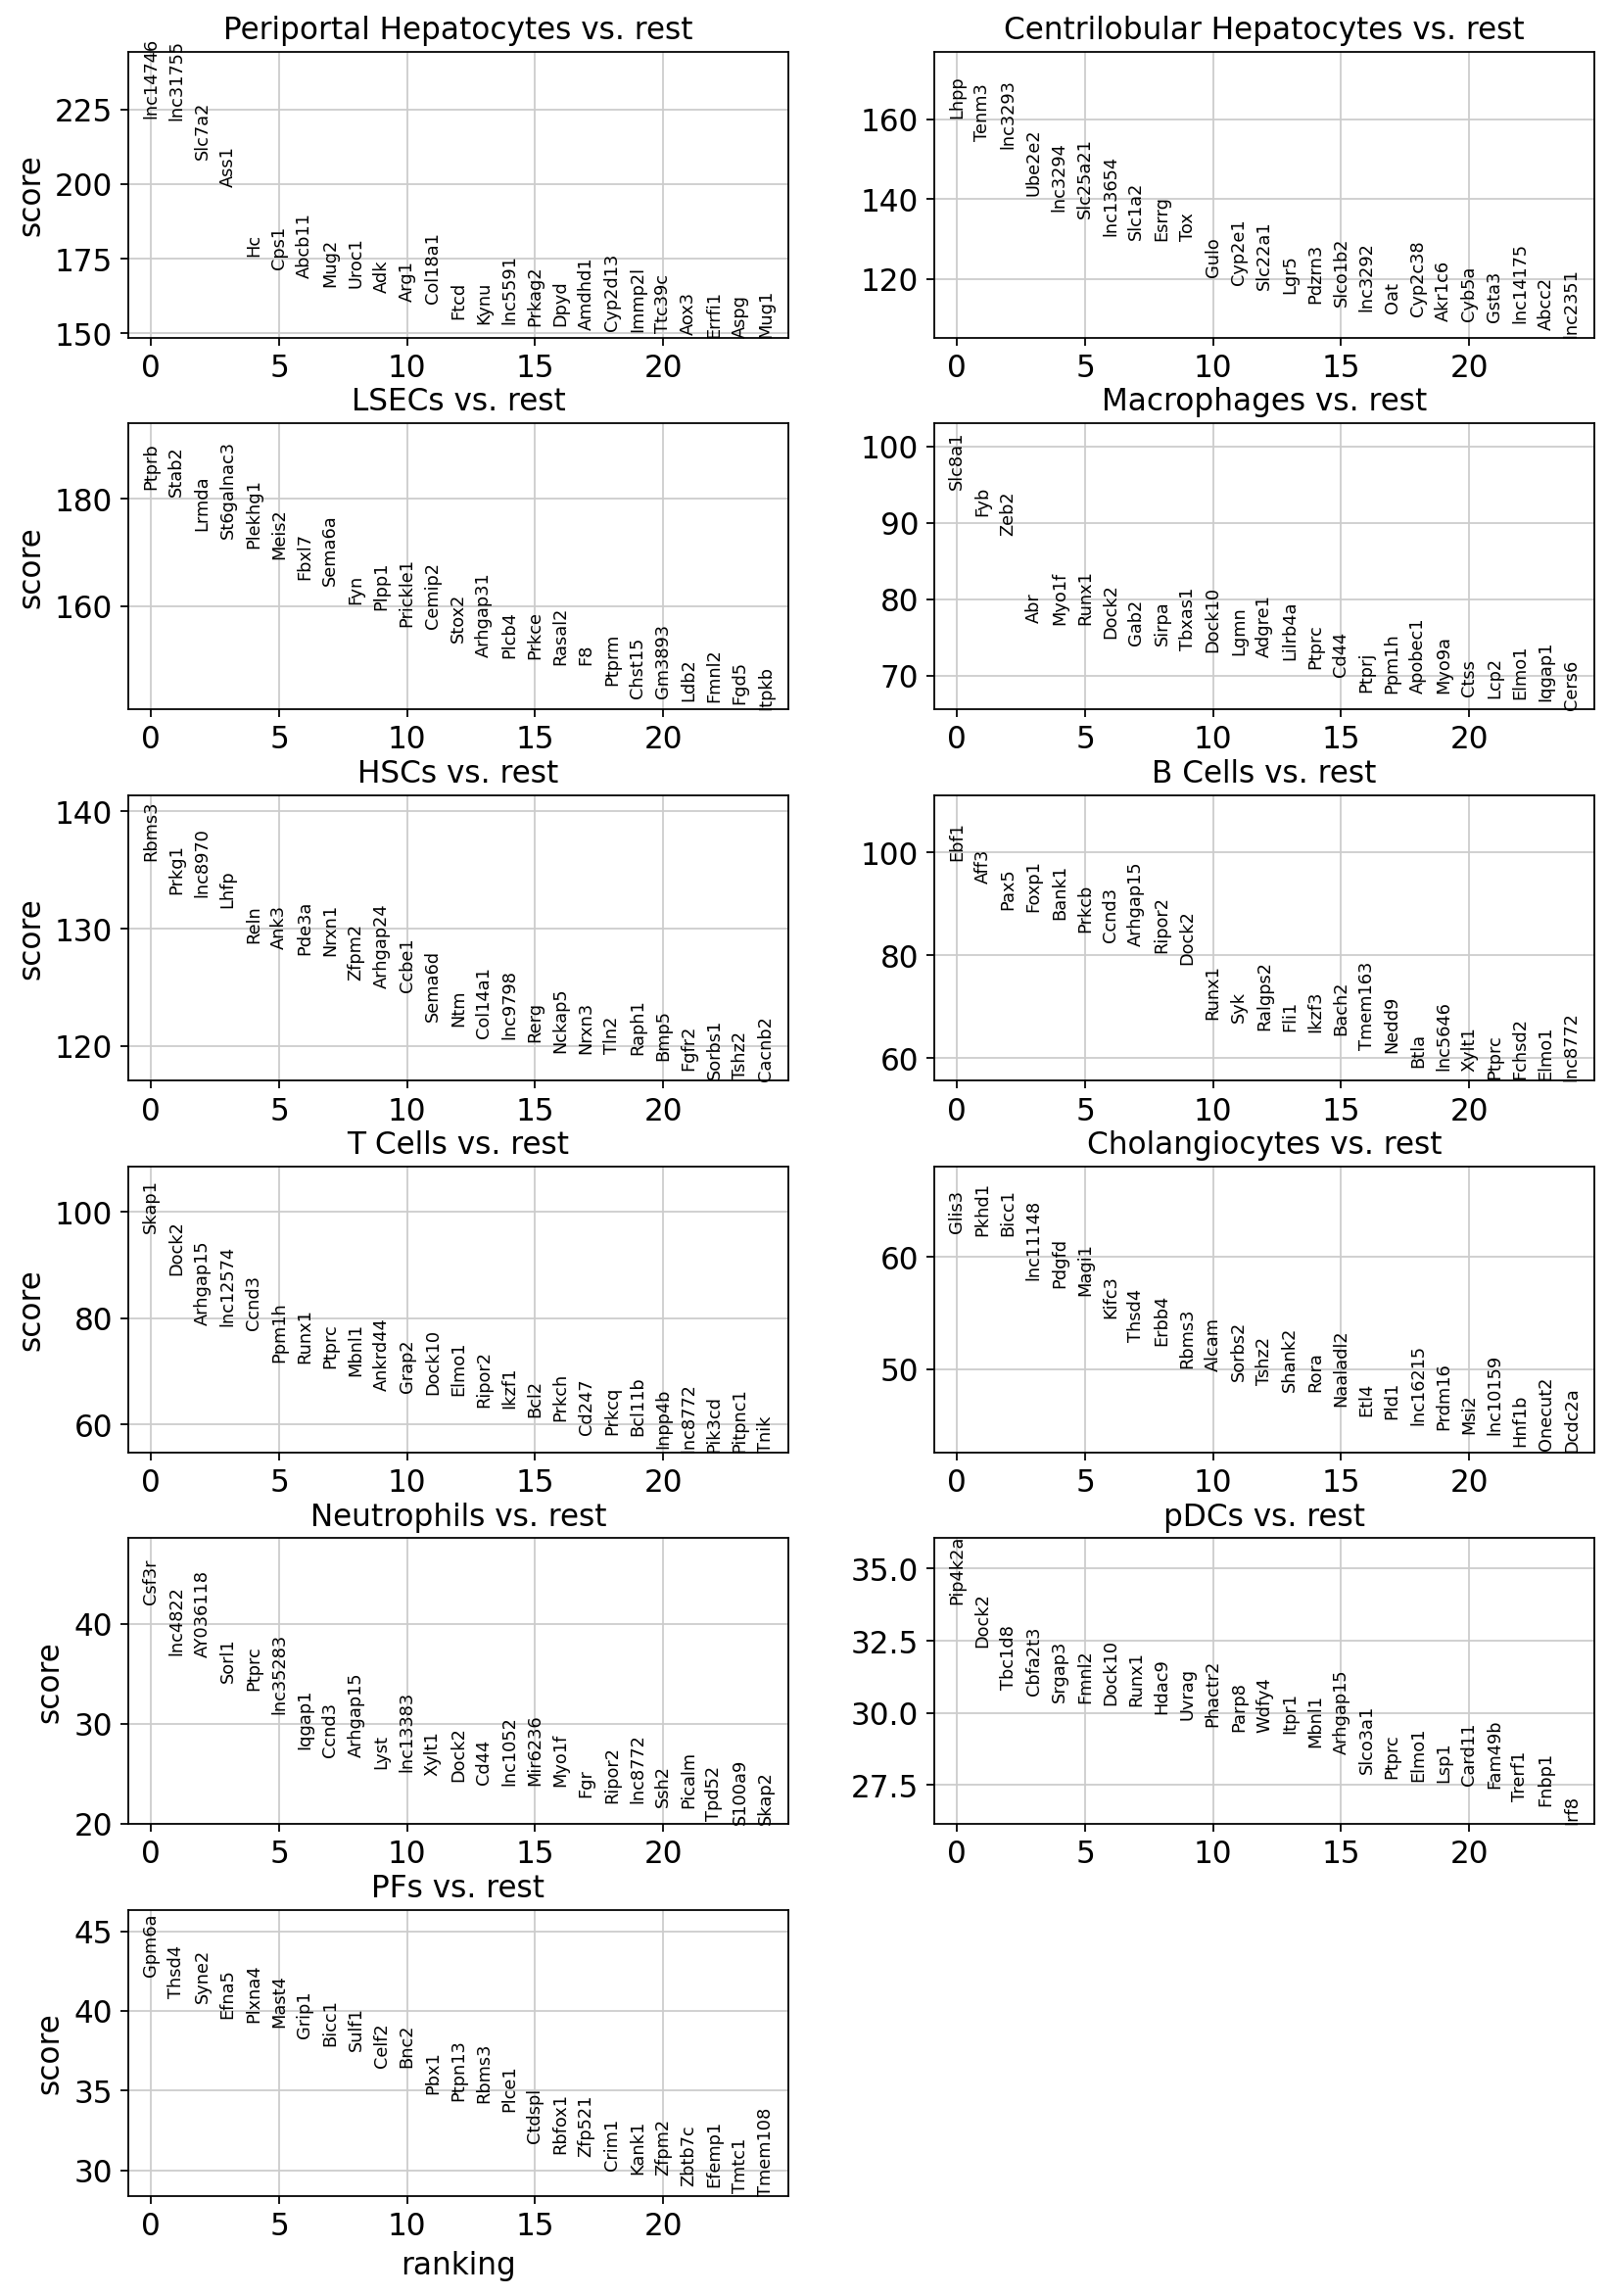

In [22]:
# Set figure size for rank genes group plot
sc.set_figure_params(figsize=(6,3))

# Plot top 25 ranked genes per cell type using Wilcoxon test results
sc.pl.rank_genes_groups(cdata, 
                        n_genes=25, 
                        sharey=False, 
                        key="Celltype_Wilcoxon",
                        ncols=2,
                        save='_Ranked_Genes_For_Each_Celltype.pdf'
                       )

# <br> 7. Save Everything

In [23]:
cdata

AnnData object with n_obs × n_vars = 115879 × 49633
    obs: 'OrigIdent', 'Barcode', 'OrigIdent-Barcode', 'Dose', 'Celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Celltype_colors', 'OrigIdent_colors', 'log1p', 'Dose_colors', 'Celltype_Wilcoxon'
    obsm: 'X_umap'
    layers: 'counts', 'log1p_counts'

Add more metadata

In [24]:
cdata.obs['OrigIdent_Celltype'] = cdata.obs['OrigIdent'].astype(str).str.cat(cdata.obs['Celltype'], sep="_")


Save AnnData Object

In [25]:
cdata.write_h5ad('./Adata_Objects/02b_RDDR_AllGenes_Clustered_And_Annotated_Cells.h5ad',compression='gzip')
